In [93]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory

In [94]:
from ReactorCool import simulator

In [95]:
env = simulator()
nb_actions = env.action_space.n
env.observation_space, env.action_space

(Box(2,), Discrete(3))

In [96]:
print(env.T)
env.step(1), env.step(2), env.step(3)
print(env.T)

[600]
[600, 580.0, 600.0, 600.0]


In [97]:
y = [] 
x = []
CSTR = []
PFR = []

for i in range(0, 50):
    test1 = simulator()
    test2 = simulator()
    x.append(i/50)
    test1.X.append(i/50)
    test2.X.append(i/50)
    test1.simulate(0)
    test2.simulate(1)
    CSTR.append(test1.state[0])
    PFR.append(test2.state[0])
    if CSTR[-1] >0.999 or PFR[-1] > 0.999: break

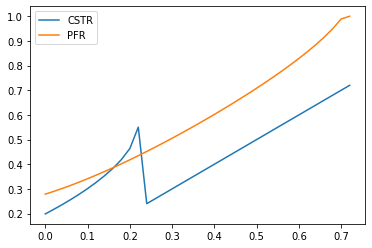

In [98]:
plt.plot(x, CSTR)
plt.plot(x, PFR)
plt.legend(["CSTR", "PFR"])

In [99]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(nb_actions, activation = 'linear'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_17 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_18 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 51        
Total params: 643
Trainable params: 643
Non-trainable params: 0
_________________________________________________________________
None


In [100]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.2, value_test= 0, nb_steps=10000)
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, enable_double_dqn = True,  
               enable_dueling_network = True, nb_steps_warmup=9, target_model_update=1e-2, policy=policy, gamma = 0.95, delta_clip = 1)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [101]:
hist = dqn.fit(env, nb_steps=30000)

Training for 30000 steps ...
Interval 1 (0 steps performed)
   46/10000 [..............................] - ETA: 7:29 - reward: 0.0524

C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\rl\memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 44s 4ms/step - reward: 0.0598
1111 episodes - episode_reward: 0.538 [0.232, 0.974] - loss: 0.771 - mean_absolute_error: 1.728 - mean_q: -1.196 - mean_eps: 0.600

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 42s 4ms/step - reward: 0.0666
1111 episodes - episode_reward: 0.599 [0.232, 0.974] - loss: 0.026 - mean_absolute_error: 0.242 - mean_q: 0.371 - mean_eps: 0.200

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 42s 4ms/step - reward: 0.0658
done, took 129.068 seconds


In [102]:
print(hist.history.keys())

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


In [103]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

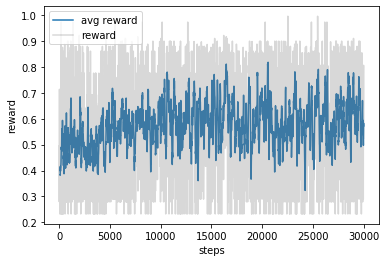

In [104]:
smoothed_rews = running_mean(hist.history['episode_reward'], 10)
plt.plot(hist.history['nb_steps'][-len(smoothed_rews):], smoothed_rews)
plt.plot(hist.history['nb_steps'],hist.history['episode_reward'],color='grey', alpha=0.3)
plt.xlabel("steps")
plt.ylabel("reward")
plt.legend(["avg reward", "reward"])

In [105]:
dqn.test(env, visualize = True)

Testing for 1 episodes ...
choice(1) -  units: ['CSTR'], conversions: [0, 0.19846197467290191], Temps: [600, 570.0]
choice(2) -  units: ['CSTR', 'CSTR'], conversions: [0, 0.19846197467290191, 0.23215616364133973], Temps: [600, 570.0, 540.0]
choice(3) -  units: ['CSTR', 'CSTR', 'CSTR'], conversions: [0, 0.19846197467290191, 0.23215616364133973, 0.23215616364133973], Temps: [600, 570.0, 540.0, 510.0]
choice(4) -  units: ['CSTR', 'CSTR', 'CSTR', 'Cooler'], conversions: [0, 0.19846197467290191, 0.23215616364133973, 0.23215616364133973, 0.23215616364133973], Temps: [600, 570.0, 540.0, 510.0, 600.0]
choice(5) -  units: ['CSTR', 'CSTR', 'CSTR', 'Cooler', 'CSTR'], conversions: [0, 0.19846197467290191, 0.23215616364133973, 0.23215616364133973, 0.23215616364133973, 0.23215616364133973], Temps: [600, 570.0, 540.0, 510.0, 600.0, 570.0]
choice(6) -  units: ['CSTR', 'CSTR', 'CSTR', 'Cooler', 'CSTR', 'CSTR'], conversions: [0, 0.19846197467290191, 0.23215616364133973, 0.23215616364133973, 0.2321561636

In [106]:
env.unit_seq

['CSTR', 'CSTR', 'CSTR', 'Cooler', 'CSTR', 'CSTR', 'CSTR', 'Cooler', 'CSTR']

In [107]:
y = [] 
x = []
CSTR = []
PFR = []

for i in range(0, 50):
    test1 = simulator()
    test2 = simulator()
    x.append(i/50)
    test1.X.append(i/50)
    test2.X.append(i/50)
    test1.simulate(0)
    test2.simulate(1)
    CSTR.append(test1.state[0])
    PFR.append(test2.state[0])
    if CSTR[-1] >0.999 or PFR[-1] > 0.999: break

Text(0, 0.5, 'x next')

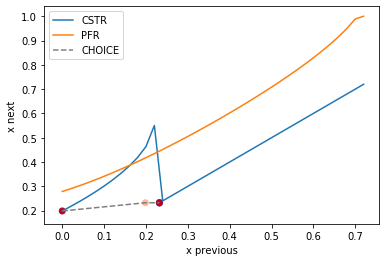

In [108]:
x_sim = env.X[0:-1]
temps = env.T[0:-1]
choice = env.X[1:]
plt.plot(x, CSTR)
plt.plot(x, PFR)
plt.plot(x_sim, choice, linestyle = '--', c = 'tab:grey')
plt.scatter(x_sim, choice, c = temps, cmap = 'coolwarm')
plt.legend(["CSTR", "PFR", "CHOICE"])
plt.xlabel("x previous")
plt.ylabel("x next")

In [32]:
??dqn

In [39]:
??env

In [10]:
??dqn.fit

In [9]:
??dqn.forward

In [24]:
??SequentialMemory